1. Data Exploration & Preparation

* Load the dataset from Kaggle.

* Explore and summarize key fields, such as project description, title, short summary, and other textual attributes. Understand distributions and class balances.

* Identify your target variable (e.g., "funded" vs. "not funded") and evaluate class imbalance.

In [1]:
pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("/content/Preprocessed_DonorsChoose_dataset.csv")

In [3]:
df.head()
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 14 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            109248 non-null  object 
 1   teacher_prefix                                109248 non-null  object 
 2   school_state                                  109248 non-null  object 
 3   project_grade_category                        109248 non-null  object 
 4   project_subject_categories                    109248 non-null  object 
 5   project_subject_subcategories                 109248 non-null  object 
 6   teacher_number_of_previously_posted_projects  109248 non-null  int64  
 7   project_is_approved                           109248 non-null  int64  
 8   price                                         109248 non-null  float64
 9   quantity                                      10

(109248, 14)

NLP Preprocessing Pipeline

* Clean text: lowercasing, remove punctuation, stop-words, HTML tags, numbers, special characters.

* Tokenize text efficiently.

* Consider lemmatization or stemming.

* Optionally remove low-frequency words or phrases.

* Prepare your text as required for different embedding approaches.

In [4]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['cleaned_essays'].apply(clean_text)
print(df[['cleaned_essays', 'clean_text']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                      cleaned_essays  \
0  students english learners working english seco...   
1  students arrive school eager learn polite gene...   
2  true champions not always ones win guts mia ha...   
3  work unique school filled esl english second l...   
4  second grade classroom next year made around 2...   

                                          clean_text  
0  student english learner working english second...  
1  student arrive school eager learn polite gener...  
2  true champion always one win gut mia hamm quot...  
3  work unique school filled esl english second l...  
4  second grade classroom next year made around k...  


Embedding Approaches

* TF-IDF: Vectorize your text fields (try different n-grams: uni-grams, bi-grams up to trigrams).

* Pre-trained Word2Vec: Use a widely available pre-trained model (e.g., Google News vectors or similar). Map words to embeddings and compute document-level representations (e.g., averaging, TF-IDF-weighted averaging).

* (Optional extension) Train your own Word2Vec (skip-gram or CBOW) on the dataset to compare.

In [5]:
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['project_is_approved']  # Target (1=approved, 0=not approved)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train), "Test size:", len(X_test))

Train size: 87398 Test size: 21850


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1,2))  # Uni+bi-grams
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF shape:", X_train_tfidf.shape)

TF-IDF shape: (87398, 2000)


In [7]:
import gensim.downloader as api
import numpy as np

w2v = api.load("word2vec-google-news-300")

def get_w2v_vector(text):
    words = text.split()
    words = [w for w in words if w in w2v]
    if len(words) == 0:
        return np.zeros(300)
    return np.mean([w2v[w] for w in words], axis=0)

X_train_w2v = np.vstack(X_train.apply(get_w2v_vector))
X_test_w2v = np.vstack(X_test.apply(get_w2v_vector))

print("Word2Vec shape:", X_train_w2v.shape)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2Vec shape: (87398, 300)


4. Classical ML Models

*Train at least two classifiers using the TF-IDF (and/or Word2Vec) embeddings:

Examples: Logistic Regression, Support Vector Machine (SVM), Random Forest, XGBoost, etc.

* Use cross-validation to tune hyperparameters.

* Report performance metrics: accuracy, precision, recall, F1-score, and confusion matrix.

Logistic Regression (TF-IDF):
              precision    recall  f1-score   support

           0       0.59      0.04      0.07      3308
           1       0.85      1.00      0.92     18542

    accuracy                           0.85     21850
   macro avg       0.72      0.52      0.50     21850
weighted avg       0.81      0.85      0.79     21850



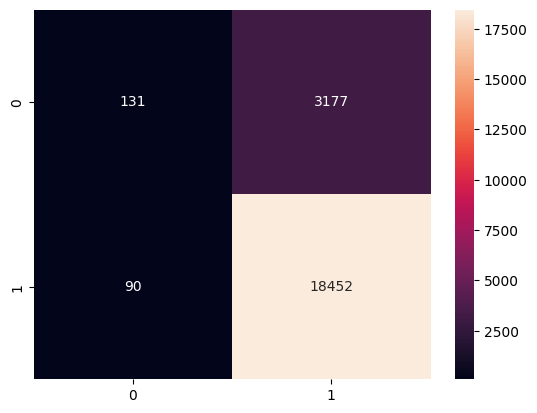

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Logistic Regression with TF-IDF
lr = LogisticRegression(max_iter=200)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

print("Logistic Regression (TF-IDF):")
print(classification_report(y_test, y_pred_lr))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d")
plt.show()

5. Deep Learning Models

* Construct at least one deep learning classifier using TensorFlow/Keras or PyTorch.

   * Your model should:

   * Take multiple embedding inputs: e.g., TF-IDF vector + averaged Word2Vec embedding (or even both pre-trained and custom Word2Vec).

  * Use the functional API (if using Keras) to combine these inputs:

   * Example: Input layer for TF-IDF → Dense subnetwork; Input layer for Word2Vec embedding → Dense subnetwork; then merge with concatenate, followed by further dense layers and output.

   * Optionally add dropout, batch normalization, activation tuning (ReLU, LeakyReLU, etc.), and regularization.

* Train with appropriate loss function, optimizer, and learning rate schedule.

* Evaluate using the same metrics as classical models.

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# Convert TF-IDF sparse matrix to dense (small dataset is fine, else sample)
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

# Input 1: TF-IDF
input_tfidf = Input(shape=(X_train_tfidf_dense.shape[1],), name="tfidf_input")
x1 = layers.Dense(128, activation="relu")(input_tfidf)
x1 = layers.Dropout(0.3)(x1)

# Input 2: Word2Vec
input_w2v = Input(shape=(300,), name="w2v_input")
x2 = layers.Dense(128, activation="relu")(input_w2v)
x2 = layers.Dropout(0.3)(x2)

# Merge
merged = layers.concatenate([x1, x2])
x = layers.Dense(64, activation="relu")(merged)
output = layers.Dense(1, activation="sigmoid")(x)

# Build model
model = Model(inputs=[input_tfidf, input_w2v], outputs=output)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tfidf_input         │ (None, 2000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ w2v_input           │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    256,128 │ tfidf_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     38,528 │ w2v_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 311,169 (1.19 MB)

 Trainable params: 311,169 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    [X_train_tfidf_dense, X_train_w2v],
    y_train,
    validation_data=([X_test_tfidf_dense, X_test_w2v], y_test),
    epochs=5,
    batch_size=16
)

# Evaluate
loss, acc = model.evaluate([X_test_tfidf_dense, X_test_w2v], y_test)
print(f"Test Accuracy: {acc:.4f}")

Epoch 1/5
5463/5463 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - accuracy: 0.8466 - loss: 0.4056 - val_accuracy: 0.8512 - val_loss: 0.3843
Epoch 2/5
5463/5463 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.8542 - loss: 0.3745 - val_accuracy: 0.8513 - val_loss: 0.3821
Epoch 3/5
5463/5463 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - accuracy: 0.8605 - loss: 0.3614 - val_accuracy: 0.8503 - val_loss: 0.3838
Epoch 4/5
5463/5463 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - accuracy: 0.8746 - loss: 0.3299 - val_accuracy: 0.8454 - val_loss: 0.3936
Epoch 5/5
5463/5463 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.8946 - loss: 0.2887 - val_accuracy: 0.8422 - val_loss: 0.4081
683/683 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8472 - loss: 0.3992
Test Accuracy: 0.8422


6. Model Comparison & Analysis
* Compare classical vs. deep learning models using validation/test performance.

* Analyze strengths and weaknesses: which models perform best? Where do certain models fail?

* Provide confusion matrices, ROC curves, precision–recall plots, etc.

* Discuss reasons for performance differences and potential improvements.

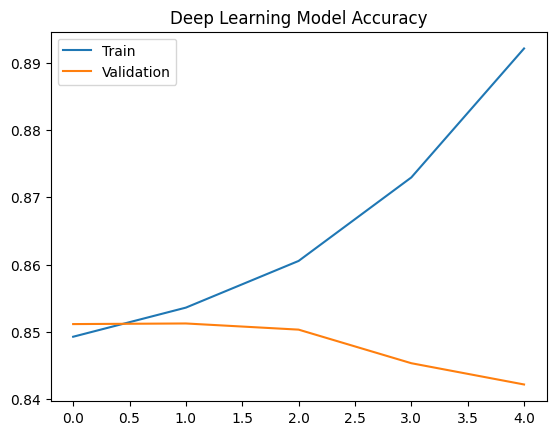

In [11]:
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.legend()
plt.title("Deep Learning Model Accuracy")
plt.show()